# Лабораторная работа №8

## Динамические сети

## Вариант 23
Целью работы является исследование свойств некоторых динамических нейронных сетей,
алгоритмов обучения, а также применение сетей в задачах аппроксимации функций и распознавания динамических образов.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from collections import deque
from tqdm import tqdm

/home/prota/Neuroinformatics_labs/env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Реализую модель динамической сети.

In [2]:
class TDL(nn.Module):
    def __init__(self, in_features, delays):
        super(TDL, self).__init__()
        self.in_features = in_features
        self.delays = delays
        self.line = deque()
        self.clear()
        
    def clear(self):
        self.line.clear()
        for _ in range(self.delays):
            self.line.append(torch.zeros(1, self.in_features))
    
    def push(self, x):
        self.line.appendleft(x)
    
    def forward(self):
        return self.line.pop()

class NARX(nn.Module):
    def __init__(self, in_features, hi_features, out_features, delay1, delay2):
        super(NARX, self).__init__()        
        self.line1 = TDL(in_features, delay1)
        self.line2 = TDL(out_features, delay2)
        
        self.w1 = nn.Parameter(torch.randn(in_features, hi_features))
        self.w2 = nn.Parameter(torch.randn(out_features, hi_features))
        self.w3 = nn.Parameter(torch.randn(hi_features, out_features))
        
        self.b1 = nn.Parameter(torch.zeros(hi_features))
        self.b2 = nn.Parameter(torch.zeros(out_features))
        
    def clear(self):
        self.line1.clear()
        self.line2.clear()
        
    def forward(self, x):
        out1 = torch.tanh(self.line1()@self.w1+self.b1+self.line2()@self.w2)
        out2 = out1@self.w3+self.b2
        
        self.line1.push(x.detach().clone())
        self.line2.push(out2.detach().clone())
        return out2

Сгенерирую данные.

In [3]:
def f(x):
    return np.sin(x**2+3*x)+np.sin(x)

h = 0.01
x = np.arange(0, 10+h, h)

u = f(x)

v = [0]
for i in range(len(x)-1):
    v.append(v[i]/(1+v[i]**2)+u[i]**3)

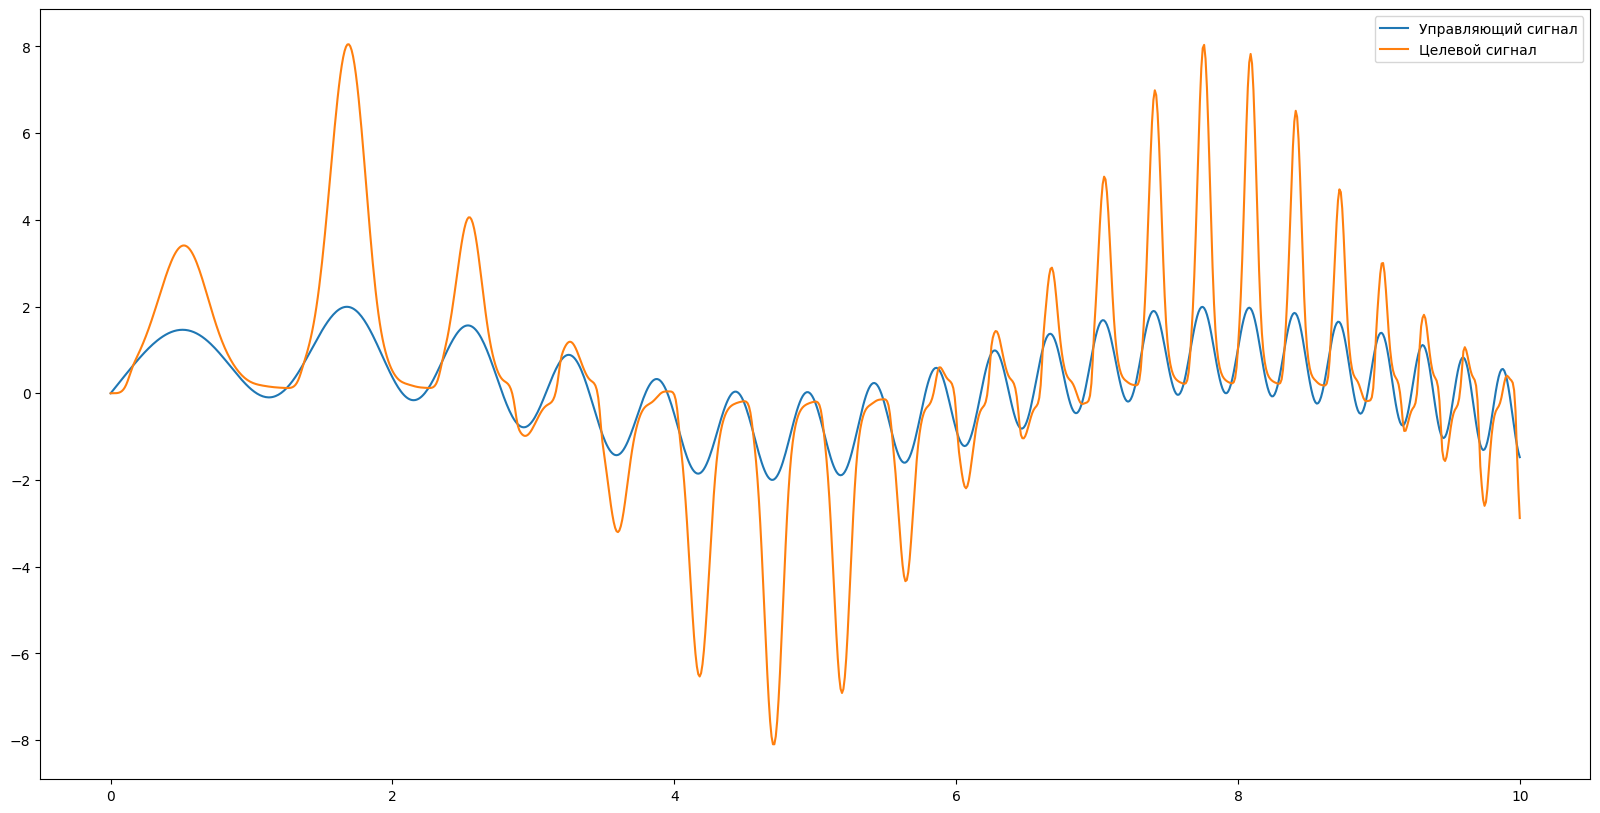

In [4]:
fig = plt.figure(figsize=(20, 10))
plt.plot(x, u, label='Управляющий сигнал')
plt.plot(x, v, label='Целевой сигнал')
plt.legend()
plt.show()

Оберну данные в DataLoader.

In [5]:
window_size = 5

def make_train_data(signal, labels, window):
    train_signal = [np.array(signal[i:i+window], dtype = np.float32) for i in range(len(signal)-window)]
    train_labels = [np.array(labels[i:i+window], dtype = np.float32) for i in range(len(labels)-window)]

    return [(x, y) for x, y in zip(train_signal, train_labels)]

train_data = make_train_data(u, v, window_size)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=1, shuffle=False)

Обучу модель.

In [6]:
model = NARX(window_size, 20, window_size, 3, 3)

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
criterion = nn.MSELoss()

In [7]:
epochs = 1000
history = []

model.train()
for i in range(epochs):
    model.clear()
    losses = []

    progress_tqdm = tqdm(enumerate(train_loader))

    for j, (input, output_gt) in progress_tqdm:
        
        output = model(input)

        loss = torch.sqrt(criterion(output_gt, output))
        losses += [loss.item()]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    history += [np.mean(losses)]

996it [00:02, 354.93it/s]
996it [00:04, 206.51it/s]
996it [00:04, 205.41it/s]
996it [00:02, 423.58it/s]
996it [00:04, 206.59it/s]
996it [00:02, 395.44it/s]
996it [00:02, 377.51it/s]
996it [00:05, 183.55it/s]
996it [00:02, 407.08it/s]
996it [00:03, 294.31it/s]
996it [00:04, 220.89it/s]
996it [00:02, 360.33it/s]
996it [00:03, 282.74it/s]
996it [00:03, 256.40it/s]
996it [00:02, 458.79it/s]
996it [00:02, 376.66it/s]
996it [00:04, 239.34it/s]
996it [00:02, 423.03it/s]
996it [00:02, 410.01it/s]
996it [00:04, 199.52it/s]
996it [00:02, 389.67it/s]
996it [00:02, 467.45it/s]
996it [00:03, 304.31it/s]
996it [00:03, 283.69it/s]
996it [00:02, 488.95it/s]
996it [00:01, 507.74it/s]
996it [00:03, 288.62it/s]
996it [00:02, 339.97it/s]
996it [00:02, 457.91it/s]
996it [00:02, 418.25it/s]
996it [00:03, 255.12it/s]
996it [00:02, 397.01it/s]
996it [00:01, 512.86it/s]
996it [00:02, 365.10it/s]
996it [00:04, 241.65it/s]
996it [00:01, 503.91it/s]
996it [00:02, 432.57it/s]
996it [00:03, 306.65it/s]
996it [00:03

In [8]:
model.eval()
model.clear()

predictions = []
for input, output_gt in train_loader:
    predictions += [model(input).detach().numpy()]
predictions = np.array(predictions)

Взгляну на результаты предсказания целевого сигнала.

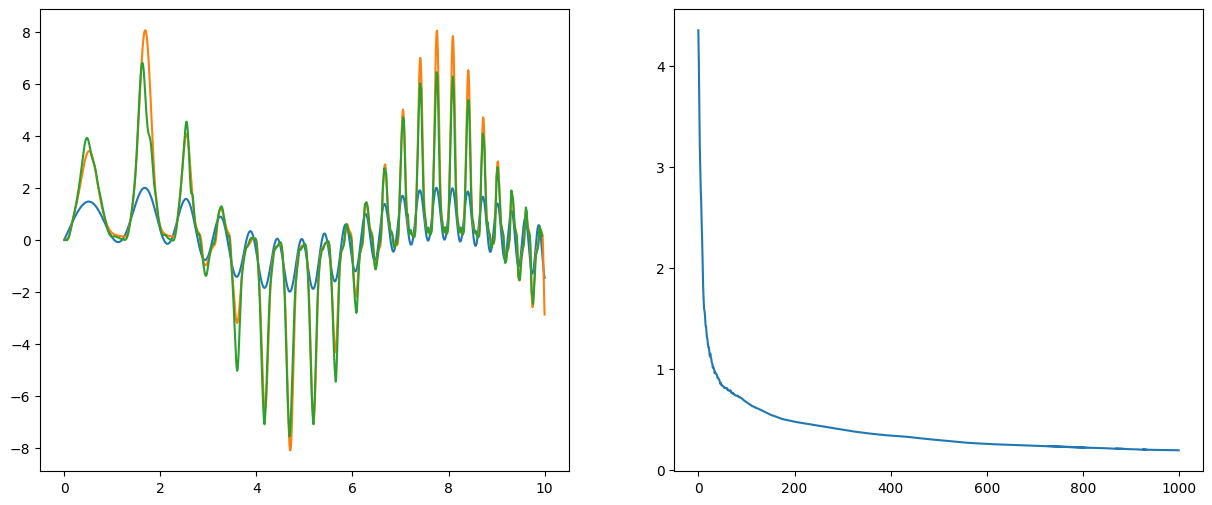

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[0].plot(x, u, label='Управляющий сигнал')
ax[0].plot(x, v, label='Целевой сигнал')
ax[0].plot(x[:-window_size], predictions[:, 0, 0], label='Предсказание')

ax[1].plot(history)

plt.show()

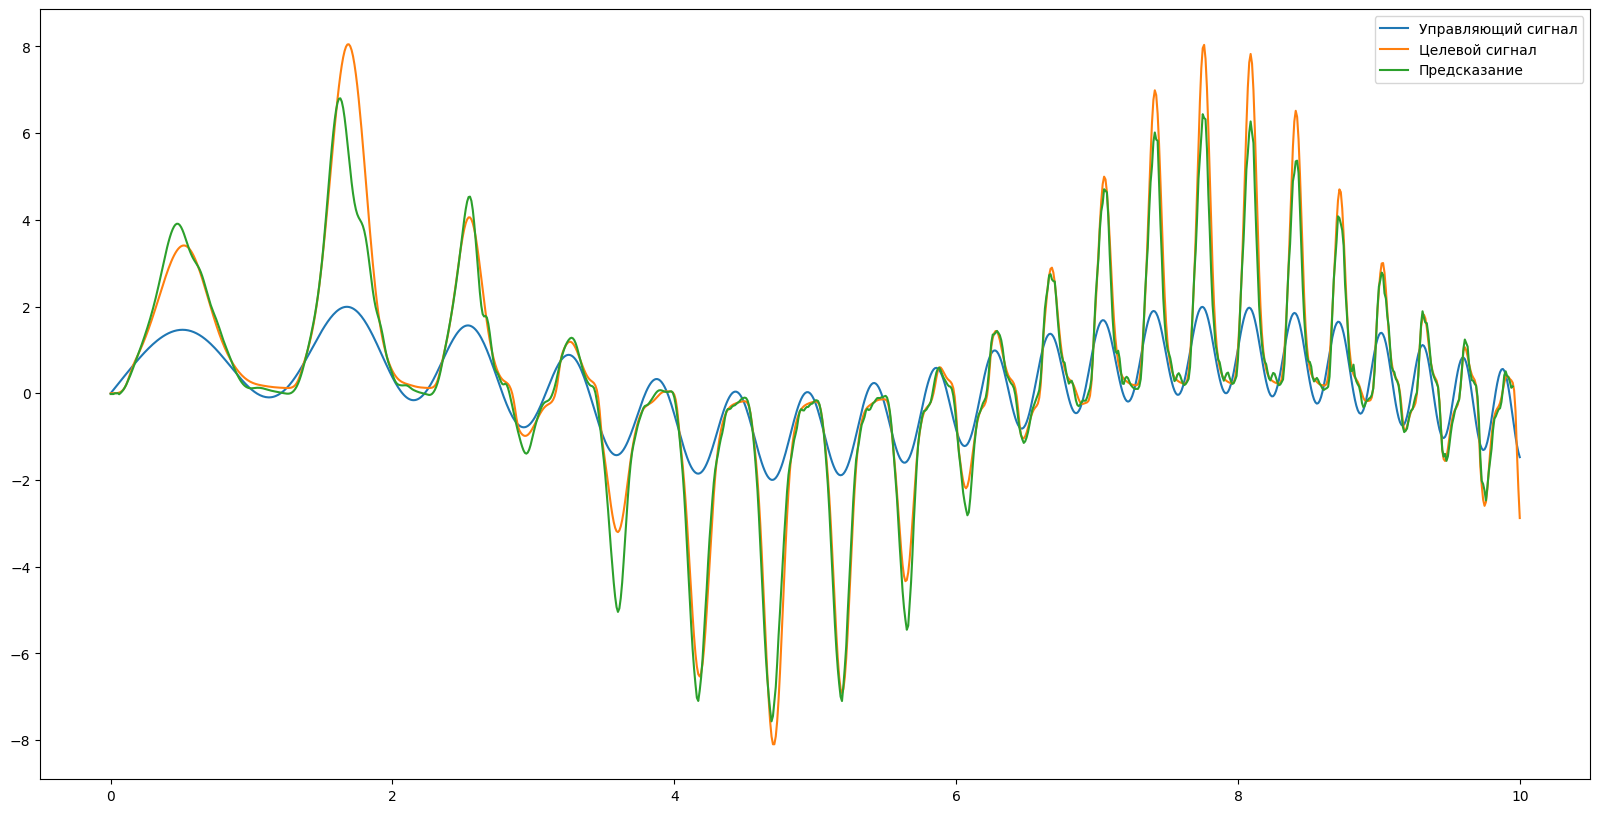

In [10]:
fig = plt.figure(figsize=(20, 10))
plt.plot(x, u, label='Управляющий сигнал')
plt.plot(x, v, label='Целевой сигнал')
plt.plot(x[:-window_size], predictions[:, 0, 0], label='Предсказание')

plt.legend()
plt.show()

__Вывод__: В ходе выполнения лабораторной работы была реализована нейросетевая модель NARX и была обучена для восстановления целевого сигнала по поведению управляющего. Модель пришлось обучать на большом количестве эпох, так как при их малом количестве, целевой сигнал восстанавливался с довольно ощутимым шумом.